In [12]:
using Pkg
# Pkg.activate(".")
# Pkg.instantiate()
using Revise
using EasyHybrid
using Lux
using Optimisers
using WGLMakie
using Random
using LuxCore
using CSV, DataFrames
using EasyHybrid.MLUtils
using Statistics
using Plots
using JLD2


In [13]:
# 03 - flexiable BD, both oBD and mBD will be learnt by NN
testid = "03_hybridNN";
version = "v20251209"
results_dir = joinpath(@__DIR__, "eval");
target_names = [:BD, :SOCconc, :CF, :SOCdensity];

# input
df = CSV.read(joinpath(@__DIR__, "data/lucas_preprocessed_v20251125.csv"), DataFrame; normalizenames=true)
println(size(df))

# scales
scalers = Dict(
    :SOCconc   => 0.151, # g/kg, log(x+1)*0.151
    :CF        => 0.263, # percent, log(x+1)*0.263
    :BD        => 0.529, # g/cm3, x*0.529
    :SOCdensity => 0.167, # kg/m3, log(x)*0.167
);

# mechanistic model
function SOCD_model(; SOCconc, CF, oBD, mBD)
    ϵ = 1e-7

    # invert transforms
    soct = (exp.(SOCconc ./ scalers[:SOCconc]) .- 1) ./ 1000
    soct = clamp.(soct, ϵ, Inf)
    
    cft = (exp.(CF ./ scalers[:CF]) .- 1) ./ 100
    cft = clamp.(cft, 0, 0.99)

    # compute BD safely
    som = 1.724f0 .* soct
    
    denom = som .* mBD .+ (1f0 .- som) .* oBD
    denom = clamp.(denom, ϵ, Inf)

    BD = (oBD .* mBD) ./ denom
    BD = clamp.(BD, ϵ, Inf)

    # SOCdensity
    SOCdensity = soct .* 1000 .* BD .* (1 .- cft)
    SOCdensity = clamp.(SOCdensity, 1, Inf)

    # scale
    SOCdensity = log.(SOCdensity) .* scalers[:SOCdensity]
    BD = BD .* scalers[:BD]

    return (; BD, SOCconc, CF, SOCdensity, oBD, mBD)
end


# param bounds
parameters = (
    SOCconc = (0.01f0, 0.0f0, 1.0f0),   # fraction
    CF      = (0.15f0, 0.0f0, 1.0f0),   # fraction,
    oBD     = (0.20f0, 0.05f0, 0.40f0),  # also NN learnt, g/cm3
    mBD     = (1.20f0, 0.75f0, 2.0f0),  # NN leanrt
)

# define param for hybrid model
neural_param_names = [:SOCconc, :CF, :mBD, :oBD]
# global_param_names = [:oBD]
forcing = Symbol[]
targets = [:BD, :SOCconc, :SOCdensity, :CF]       # SOCconc is both a param and a target

# predictor
predictors = Symbol.(names(df))[18:end-6]; # CHECK EVERY TIME 
nf = length(predictors)


(56117, 385)


362

In [14]:
# hyperparameters
# search space
hidden_configs = [ 
    (512, 256, 128, 64, 32, 16),
    (512, 256, 128, 64, 32), 
    (256, 128, 64, 32, 16),
    (256, 128, 64, 32),
    (256, 128, 64),
    (128, 64, 32, 16),
    (128, 64, 32),
    (64, 32, 16)
];
batch_sizes = [128, 256, 512];
lrs = [1e-3, 5e-4, 1e-4];
activations = [relu, swish, gelu];

configs = [(h=h, bs=bs, lr=lr, act=act)
           for h in hidden_configs
           for bs in batch_sizes
           for lr in lrs
           for act in activations]

println(length(configs))


216


In [15]:
# cross-validation
k = 5;
folds = make_folds(df, k = k, shuffle = true);
rlt_list_param = Vector{DataFrame}(undef, k)
rlt_list_pred = Vector{DataFrame}(undef, k)  

@info "Threads available: $(Threads.nthreads())"

[ Info: Threads available: 96


In [16]:

@time for test_fold in 1:k
    @info "Training outer fold $test_fold of $k"

    train_folds = setdiff(1:k, test_fold)
    train_idx = findall(in(train_folds), folds)
    train_df = df[train_idx, :]
    test_idx  = findall(==(test_fold), folds)
    test_df = df[test_idx, :]

    # track best config for this outer fold
    lk = ReentrantLock()
    best_val_loss = Inf
    best_config = nothing
    best_result = nothing
    best_model_path = nothing
    best_model = nothing

    Threads.@threads for i in 1:length(configs)
        try
            cfg = configs[i]
        
            h  = cfg.h
            bs = cfg.bs
            lr = cfg.lr
            act = cfg.act
            println("Testing h=$h, bs=$bs, lr=$lr, activation=$act")
    
            hm_local = constructHybridModel(
                predictors,
                forcing,
                targets,
                SOCD_model,
                parameters,
                neural_param_names,
                [];
                hidden_layers = collect(h),
                activation = act,
                scale_nn_outputs = true,
                input_batchnorm = false,
                start_from_default = true
            )
    
            rlt = train(
                hm_local, train_df, ();
                nepochs = 200,
                batchsize = bs,
                opt = AdamW(lr),
                training_loss = :mse,
                loss_types = [:mse, :r2],
                shuffleobs = true,
                file_name = "$(testid)_config$(i)_fold$(test_fold).jld2",
                random_seed = 42,
                patience = 15,
                yscale = identity,
                monitor_names = [:oBD, :mBD],
                agg = mean,
                return_model = :best,
                show_progress = false,
                plotting = false,
                hybrid_name = "$(testid)_config$(i)_fold$(test_fold)" 
            )
    
            lock(lk)
            if rlt.best_loss < best_val_loss
                best_val_loss = rlt.best_loss
                best_config = cfg
                best_result = rlt
                best_model_path = "best_model_$(testid)_config$(i)_fold$(test_fold).jld2"
                best_model = deepcopy(hm_local)
            end
            unlock(lk)
        catch err
            @error "Thread $i crashed" exception = err
            @error sprint(showerror, err)
        end

    end

    # register best hyper paramets
    agg_name = Symbol("mean")
    r2s  = map(vh -> getproperty(vh, agg_name), best_result.val_history.r2)
    mses = map(vh -> getproperty(vh, agg_name), best_result.val_history.mse)
    best_epoch = max(best_result.best_epoch, 1)

    local_results_param = DataFrame(
        h = string(best_config.h),
        bs = best_config.bs,
        lr = best_config.lr,
        act = string(best_config.act),
        r2 = r2s[best_epoch],
        mse = mses[best_epoch],
        best_epoch = best_epoch,
        test_fold = test_fold,
        path = best_model_path,
    )
    rlt_list_param[test_fold] = local_results_param

    # move best models and then remove tmp files
    cp(joinpath("output_tmp", best_model_path), joinpath("model", best_model_path * ".jld2"); force=true) 
    for f in readdir("output_tmp"; join=true)
        rm(f; force=true, recursive=true)
    end

    ps, st = best_result.ps, best_result.st
    (x_test,  y_test)  = prepare_data(best_model, test_df)
    ŷ_test, st_test = best_model(x_test, ps, LuxCore.testmode(st))
    # println(propertynames(ŷ_test))
    # println(propertynames(ŷ_test.parameters))

    for var in [:BD, :SOCconc, :CF, :SOCdensity, :oBD, :mBD]
        if hasproperty(ŷ_test, var)
            val = getproperty(ŷ_test, var)

            if val isa AbstractVector && length(val) == nrow(test_df)
                test_df[!, Symbol("pred_", var)] = val # per row

            elseif (val isa Number) || (val isa AbstractVector && length(val) == 1)
                test_df[!, Symbol("pred_", var)] = fill(Float32(val isa AbstractVector ? first(val) : val), nrow(test_df))
            end


        end
    end
    
    rlt_list_pred[test_fold] = test_df

end

rlt_param = vcat(rlt_list_param...)
rlt_pred = vcat(rlt_list_pred...)

CSV.write(joinpath(results_dir, "$(testid)_cv.pred_$version.csv"), rlt_pred)
CSV.write(joinpath(results_dir, "$(testid)_hyperparams_$version.csv"), rlt_param)

[ Info: Training outer fold 1 of 5


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(6

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info:

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015772122304437034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015772122304437034
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015666869556236182
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015666869556236182
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.0159395178943722
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.0159395178943722
[ Inf

Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01564444340336152
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01564444340336152
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.0157021662484486
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.0157021662484486
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015759589726397225
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015759589726397225
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDe

Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017402468003403358
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.017402468003403358


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015812085984408773
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015812085984408773


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.019032011862690247
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.019032011862690247


Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015493910397546521
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015493910397546521


Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015543335684200623
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015543335684200623
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.01813463659656766
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs

Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01551874522897187
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01551874522897187


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.015778086226188016
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.015778086226188016


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015497599168109229
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015497599168109229


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015189126029465698
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015189126029465698


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.0208912409952233
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.0208912409952233


Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01938916477838307
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01938916477838307


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01917877669635195
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01917877669635195


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015790136065942845
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015790136065942845


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.0176388310972085
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.0176388310972085


Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.018569709555610547
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.018569709555610547


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.016051620051492313
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 43 of 200 epochs with best validation loss wrt mse: 0.016051620051492313


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.015549781248456376
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.015549781248456376


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.01601185959279335
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.01601185959279335
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.019431622690285436
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.019431622690285436
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.0154391428428996
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.0154391428428996
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.018812194381274617
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.018812194381274617


Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01590039085363868
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01590039085363868


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01567707535813382
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01567707535813382
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015362526956653463
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015362526956653463


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.01605655156364839
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.01605655156364839


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.021441661555569886
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.021441661555569886


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015722607241574777
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015722607241574777
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015388294852588686
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015388294852588686
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01545963367464672
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01545963367464672


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015705432182807406
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015705432182807406
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015597193418466822
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015597193418466822


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015232283117899979
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015232283117899979


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015580602646581988
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015580602646581988


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.02025650117906727
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.02025650117906727


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.01980294291872667
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.01980294291872667


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.01779637751075988
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.01779637751075988


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.01582356017893629
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.01582356017893629
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyD

Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.018283141738339156
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.018283141738339156


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.019937700807956055
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.019937700807956055
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01544858869197184
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01544858869197184


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015691287508355554
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015691287508355554


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01953344979826767
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01953344979826767


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01860540956893309
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01860540956893309


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015468516933834834
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015468516933834834


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.01604944618338648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.01604944618338648


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.01589182374515096
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.01589182374515096
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015784608379005423
└ @ E

Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015495432037745758
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015495432037745758
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015355364871239702
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015355364871239702


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.017004012554158832
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.017004012554158832


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015608830947479072
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015608830947479072


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015408183726248878
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015408183726248878
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.021026326663505117
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.021026326663505117
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.020777230955569402
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.020777230955569402
[ Info: Check the saved ou

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017199254092004845
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.017199254092004845


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015352364055672581
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015352364055672581


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015554235404716812
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015554235404716812
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015461018840357277
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015461018840357277
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 34 with best validation loss

Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015189816059239681
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015189816059239681
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.015894271477026992
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.015894271477026992


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.01864082776080836
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.01864082776080836


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015589411271307965
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015589411271307965
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015551263835250309
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015551263835250309
┌ Warning: Early stopping at epoch 21 with best validation los

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015465032848073112
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015465032848073112
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.016106324952061116
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.016106324952061116


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015342170942633505
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015342170942633505
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015229419478422157
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015229419478422157


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.016986186566952395
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.016986186566952395


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.017021445752941473
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.017021445752941473
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015318493409135363
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015318493409135363
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.019794374520367745
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.019794374520367745
┌ Warning: Early stopping a

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 92 with best validation loss wrt mse: 0.0219840476080155
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 77 of 200 epochs with best validation loss wrt mse: 0.0219840476080155


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 102 with best validation loss wrt mse: 0.020087510418818094
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 87 of 200 epochs with best validation loss wrt mse: 0.020087510418818094


Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015486044558913696
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015486044558913696
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015808454334081
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015808454334081
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.019607657806859732
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best mod

Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015423770561435731
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015423770561435731


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 84 with best validation loss wrt mse: 0.01823902103615255
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 69 of 200 epochs with best validation loss wrt mse: 0.01823902103615255


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.017000070167383877
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.017000070167383877


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 87 with best validation loss wrt mse: 0.023001360169435298
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 72 of 200 epochs with best validation loss wrt mse: 0.023001360169435298


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015317645557258397
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015317645557258397
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.021463889681065364
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.021463889681065364


Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015312355743579108
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015312355743579108
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01560433819601216
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01560433819601216
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.017692328948243265
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.017692328948243265


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 57 with best validation loss wrt mse: 0.02330031564793355
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 42 of 200 epochs with best validation loss wrt mse: 0.02330031564793355


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015930421319463657
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015930421319463657
┌ Warning: Early stopping at epoch 73 with best validation loss wrt mse: 0.020651814775646562
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 58 of 200 epochs with best validation loss wrt mse: 0.020651814775646562


Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015720314435609662
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015720314435609662
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01527792196672336
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01527792196672336
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 124 with best validation loss

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015218567537127616
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015218567537127616


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.018969917711935645
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.018969917711935645
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.018764964228003316
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.018764964228003316
┌ Warning: Early stopping at epoch 19 with best validation loss

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015292042337338212
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015292042337338212
┌ Warning: Early stopping at epoch 84 with best validation loss wrt mse: 0.02217592517498915
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 69 of 200 epochs with best validation loss wrt mse: 0.02217592517498915
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015346540095230354
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015346540095230354
┌ Warning: Early stopping at 

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.019145912210001226
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.019145912210001226
┌ Warning: Early stopping at epoch 119 with best validation loss wrt mse: 0.020750957448384583
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 104 of 200 epochs with best validation loss wrt mse: 0.020750957448384583
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.01744090347996889
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.01744090347996889
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 92 with best validation loss wrt mse: 0.02361728584867502
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 77 of 200 epochs with best validation loss wrt mse: 0.02361728584867502


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 92 with best validation loss wrt mse: 0.023714799406885506
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 77 of 200 epochs with best validation loss wrt mse: 0.023714799406885506


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015438636099121258
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Plotting disabled.
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015438636099121258
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015814193572861134
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015814193572861134
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 44 with best validation los

Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.018185415616921184
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.018185415616921184
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.016373199226883406
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.016373199226883406


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015493412980552061
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015493412980552061
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.015721623347311857
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.015721623347311857
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015487288757768974
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015487288757768974
┌ Warning: Early stopping a

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.016021501522790728
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.016021501522790728
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015099617120378973
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015099617120378973


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015190062439893591
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015190062439893591
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01523562670692873
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01523562670692873
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015090502443740803
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015090502443740803
┌ Warning: Early stopping at e

Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015228979077133557
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015228979077133557
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.015919757511044557
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.015919757511044557
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01541754058844479
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01541754058844479


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.020213494253182647
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.020213494253182647
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015741502472582717
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.015741502472582717


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.020995867142569746
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.020995867142569746
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.016187788579106105
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.016187788579106105


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015425174581074588
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015425174581074588


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01520018134889135
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01520018134889135


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015417945325269638
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015417945325269638
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01573593738177808
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01573593738177808
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015511984182897974
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning bes

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 79 with best validation loss wrt mse: 0.017289493875624482
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 64 of 200 epochs with best validation loss wrt mse: 0.017289493875624482


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015392096498571607
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015392096498571607


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015315042917678458
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015315042917678458
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015309973718572536
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015309973718572536
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015478613963828894
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015478613963828894
┌ Warning: Early stopping at

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 128 with best validation loss wrt mse: 0.021211871177221578
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 113 of 200 epochs with best validation loss wrt mse: 0.021211871177221578


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015115566190090655
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015115566190090655


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01527693300075112
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01527693300075112


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.017493943867969843
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.017493943867969843
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.0155233058625577
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.0155233058625577
┌ Warning: Early stopping at epoch 94 with best validation loss wrt mse: 0.016423041720294317
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 79 of 200 epochs with best validation loss wrt mse: 0.016423041720294317


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015432303728495259
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015432303728495259
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015631225372322324
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015631225372322324


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015387398833710401
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015387398833710401


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015170346812788761
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015170346812788761
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014964129005172522
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014964129005172522
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015157409178816254
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015575715627176159
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015575715627176159
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015338081554809929
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015338081554809929
┌ Warning: Early stopping at epoch 138 with best validation loss wrt mse: 0.0195209272842536
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 123 of 200 epochs with best validation loss wrt mse: 0.0195209272842536


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015077380496765082
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015077380496765082
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015488376697498224
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015488376697498224


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01549186212459857
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01549186212459857
[ Info: Training outer fold 2 of 5


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=swish

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=swish

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 6

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensi

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, l

┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015517280512216078
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015517280512216078


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01553932476030985
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01553932476030985


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015599679131042885
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015599679131042885


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015738884142171814
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015738884142171814
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.016024952950453236
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.016024952950453236


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.021060016528476135
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.021060016528476135
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017902483136763903
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.017902483136763903


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.017813185821354098
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.017813185821354098
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015516191990690941
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015516191990690941
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.015950526610678955
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.015950526610678955
┌ Warning: Early stopping a

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 73 with best validation loss wrt mse: 0.019174148570322222
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 58 of 200 epochs with best validation loss wrt mse: 0.019174148570322222


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015532820624934413
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015532820624934413
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015738152856207943
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015738152856207943


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015701686758628697
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015701686758628697
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015451104153764732
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015451104153764732


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.018076279492958737
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.018076279492958737


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.01747496434062539
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.01747496434062539


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01590360431990078
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01590360431990078
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.02025846810885043
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.02025846810885043
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.015603621470154958
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best 

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015739944334676716
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015739944334676716
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.019715450570395844
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.019715450570395844
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.017708491275663707
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.020051259687335496
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.020051259687335496


Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015810946885634794
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015810946885634794
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015416296606347423
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015416296606347423
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.018995139138717438
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.018995139138717438


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.015927501075763018
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.015927501075763018
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017457697527499733
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epoch

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015325688421942063
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015325688421942063


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 78 with best validation loss wrt mse: 0.02362527408370383
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 63 of 200 epochs with best validation loss wrt mse: 0.02362527408370383


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015621465020879858
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015621465020879858
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.020338949170693368
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.020338949170693368
┌ Warning: Early stopping at epoch 21 with best validation los

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.019970228479706063
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.019970228479706063
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015900699227854084
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015900699227854084
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015947307485868513
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015947307485868513
┌ Warning: Early stopping 

Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015312968088026032
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015312968088026032


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015539821783849288
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015539821783849288
┌ Warning: Early stopping at epoch 102 with best validation loss wrt mse: 0.02165000826975208
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 87 of 200 epochs with best validation loss wrt mse: 0.02165000826975208


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.018661018929848578
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.018661018929848578
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 119 with best validation loss wrt mse: 0.019388356410958516
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 104 of 200 epo

Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 75 with best validation loss wrt mse: 0.021565815594029
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 60 of 200 epochs with best validation loss wrt mse: 0.021565815594029
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015645397874609453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015645397874609453


Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015748680447130105
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015748680447130105
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.017777738648184237
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.017777738648184237


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 61 with best validation loss wrt mse: 0.023288836036080195
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 46 of 200 epochs with best validation loss wrt mse: 0.023288836036080195


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.018746157892424935
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.018746157892424935
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015440153984216838
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015440153984216838
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015473214169076726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01553007771725931
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01553007771725931
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Early stopping at epoch 81 with best validation loss wrt mse: 0.025109149803705832
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 66 of 200 epochs with best validation loss wrt mse: 0.025109149803705832
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 82 with best validation loss wrt mse: 0.023785844394711708
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 67 of 200 epochs with best validation loss wrt mse: 0.023785844394711708


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.018553402758223994
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.018553402758223994
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.018557231374584142
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.018557231374584142
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.015705671486307086
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.015705671486307086
┌ Warning: Early stopping

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01563890301671882
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01563890301671882
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01562954627396379
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01562954627396379
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.02073213863206863
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.02073213863206863


Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015488335402865226
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015488335402865226
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 124 with best validation loss wrt mse: 0.022321471706233068
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 109 of 200 epochs with best validation loss wrt mse: 0.022321471706233068
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015841382703310453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015841382703310453
┌ Warning: Early stopping

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01540869682196329
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01540869682196329


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015828926459810114
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015828926459810114
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.015660847358747867
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.015660847358747867
┌ Warning: Early stopping at epoch 64 with best validation los

Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.018952184122340617
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.018952184122340617
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.015737193942616027
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.015737193942616027
┌ Warning: Early stopping at epoch 72 with best validation loss wrt mse: 0.023445140292895475
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 57 of 200 epochs with best validation loss wrt mse: 0.023445140292895475


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.015869440621318467
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.015869440621318467
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015634831372420763
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015634831372420763


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.01734223583849423
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.01734223583849423


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015564959266556733
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015564959266556733
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015839861846830783
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015839861846830783
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015709095059073495
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015709095059073495
[ Info: Check the saved ou

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015528981561311838
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015528981561311838


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01556601498234972
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01556601498234972
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.017500435694507478
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.017500435694507478
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015642864301807953
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015642864301807953
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved outpu

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 61 with best validation loss wrt mse: 0.018482457674050892
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 46 of 200 epochs with best validation loss wrt mse: 0.018482457674050892


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015581340660272738
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.015581340660272738


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015873207800475915
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015873207800475915


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015566391421820433
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015566391421820433


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.021985911486980876
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.021985911486980876
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015531265508536094
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015531265508536094
┌ Warning: Early stopping at epoch 61 with best validation loss wrt mse: 0.020928714053080832
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015548239929392142
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015548239929392142
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01575499592799173
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01575499592799173


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015444140387576086
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015444140387576086
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015811834728445825
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015811834728445825
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015482971813139568
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.01568776908971531
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.01568776908971531
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015484018502724024
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015484018502724024


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015342605627937246
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015342605627937246
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01558806697928053
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01558806697928053
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015403520603368602
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015403520603368602
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01569118555194776
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01569118555194776
┌ Warning: Early stopping at ep

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 130 with best validation loss wrt mse: 0.02296039043375274
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 115 of 200 epochs with best validation loss wrt mse: 0.02296039043375274


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015857180449155725
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015857180449155725
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.0159279341406375
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.0159279341406375
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015730554659298915
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015730554659298915
┌ Warning: Early stopping at epo

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 106 with best validation loss wrt mse: 0.020780245672520365
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 91 of 200 epochs with best validation loss wrt mse: 0.020780245672520365


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015547862247218065
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015547862247218065
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015611933007774552
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015611933007774552
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015586148595582957
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015586148595582957


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015699109923783927
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015699109923783927
[ Info: Training outer fold 3 of 5


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 6

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=re

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh

[ Info: Plotting disabled.



Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tm

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015519689217246323
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015519689217246323
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015490896267149366
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015490896267149366
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01575502377557996
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01575502377557996
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01565450262968442
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01565450262968442
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015068021750413009
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015068021750413009
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 

Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015165032600014783
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015165032600014783
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.018414484230403913
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.018414484230403913
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015060492745682823
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014965845056783188
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014965845056783188
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015079680341313174
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015079680341313174


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014942746690678656
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014942746690678656
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01478947146935614
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01478947146935614


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015636104712985866
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015636104712985866


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu


[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015721404525413818
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015721404525413818


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.015596728932697498
└ @ EasyHybrid /opt/julia/packages/Easy

Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.015869076056506594
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.015869076056506594


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.014945064939938168
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.014945064939938168


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014919260911838726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014919260911838726


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014772407115405778
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014772407115405778
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.015384967461316786
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.015384967461316786


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01495399714464939
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01495399714464939


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.014941814907532483
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.014941814907532483


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.018651897987076962
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.018651897987076962


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015553832545244704
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015553832545244704


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015333411548131455
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015333411548131455


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015597086683060273
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015597086683060273


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.019929285717614657
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.019929285717614657


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.01871888895369478
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.01871888895369478


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014878819499052304
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014878819499052304


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.01744385318714395
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.01744385318714395


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015101171374757676
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015101171374757676
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/Easy

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015432207066692625
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015432207066692625
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01857769861252887
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01857769861252887
┌ Warning: Early stopping at epoch 65 with best validation loss wrt mse: 0.019206035600903233
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 50 of 200 epochs with best validation loss wrt mse: 0.019206035600903233


Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015754138310828815
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015754138310828815
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.019726960443455052
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.019726960443455052


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014979617493994103
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014979617493994103


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01493195004690787
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01493195004690787
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015069967765577168
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs w

Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.018949559290381467
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.018949559290381467
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.018012823511960853
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.018012823511960853


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014961038576090956
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014961038576090956


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015525532019041275
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015525532019041275
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.018470157343240905
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.018470157343240905
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.018068254125043166
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.018068254125043166


Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.01736107623357797
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.01736107623357797


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.014989024850241428
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.014989024850241428


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.019043128433877673
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.019043128433877673
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017074582864441874
└ @

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.015120709760906362
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.015120709760906362
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015204597365326354
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015204597365326354


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.018449421171265527
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.018449421171265527


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01504272339195738
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01504272339195738
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015075835866312486
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015075835866312486


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015279010521055805
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015279010521055805


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.020717045496347546
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.020717045496347546


Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015252713238892348
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015252713238892348
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015350801501476458
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015350801501476458


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.017569953238210312
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.017569953238210312


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01802800702874008
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01802800702874008


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015585405379418358
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015585405379418358
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01705155425677951
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01705155425677951


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015113798231878195
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015113798231878195


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015042117380453836
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015042117380453836


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01514181583893262
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01514181583893262
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.01983276695026976
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.01983276695026976
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015536910114634716
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015536910114634716
[ Info: Check the saved output 

Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.018537003385792457
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.018537003385792457
┌ Warning: Early stopping at epoch 49 with best validation loss wrt mse: 0.019038898815563345
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 34 of 200 epochs with best validation loss wrt mse: 0.019038898815563345
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014819901099330644
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014819901099330644
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping 

Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.020210752076463383
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.020210752076463383


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.015792390197965557
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.015792390197965557
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015179104302199754
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015179104302199754
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.014886427129496534
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01505361321504077
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01505361321504077
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014941891600870366
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014941891600870366


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014825573232334393
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014825573232334393


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.01840621234530258
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.01840621234530258
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.014992059055284617
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.014992059055284617


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014927833520374733
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014927833520374733
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01490587060636771
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01490587060636771


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015012753321819384
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015012753321819384
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014848866812145858
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014848866812145858
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01759142848025449
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015007274355365734
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015007274355365734


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01502167681067823
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01502167681067823


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01742079012475164
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01742079012475164
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.018555812280161177
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.018555812280161177
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015050502621396167
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015050502621396167
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014872902769562055
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/sr

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015129934845078186
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015129934845078186


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015436369529160368
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015436369529160368
┌ Warning: Early stopping at epoch 96 with best validation loss wrt mse: 0.019589671310657697
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 81 of 200 epochs with best validation loss wrt mse: 0.019589671310657697


Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014813873254771202
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014813873254771202
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.019186809611523654
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.019186809611523654
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015796925308426232
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015796925308426232
┌ Warning: Early stopping 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 90 with best validation loss wrt mse: 0.019317665566362566
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 75 of 200 epochs with best validation loss wrt mse: 0.019317665566362566


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015486972035410683
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015486972035410683
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.016282181824197505
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.016282181824197505


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01880817922702482
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01880817922702482
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.019232457802254264
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.019232457802254264
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.017225733096779793
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.017225733096779793


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014972301042838951
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014972301042838951


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015321138886377336
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015321138886377336
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01502572884863562
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01502572884863562


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.019188063235231964
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.019188063235231964
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.01967560497550406
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.01967560497550406


Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014955573901763105
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014955573901763105
┌ Warning: Early stopping at epoch 16 with best validation loss wrt mse: 0.01526138623548846
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 1 of 200 epochs with best validation loss wrt mse: 0.01526138623548846


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.01914988382293701
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.01914988382293701


Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 94 with best validation loss wrt mse: 0.020494196516165856
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 79 of 200 epochs with best validation loss wrt mse: 0.020494196516165856


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.0199850080819844
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.0199850080819844
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.017568236342014956
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.017568236342014956
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wr

Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015099411381193532
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015099411381193532
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.0174212456802871
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.0174212456802871
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01499839651147419
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01499839651147419
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoc

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01789702395844795
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01789702395844795
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015357073518104152
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015357073518104152
┌ Warning: Early stopping at epoch 137 with best validation loss wrt mse: 0.019887310172922987
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 122 of 200 epochs with best validation loss wrt mse: 0.019887310172922987
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.018323074220503457
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/s

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 80 with best validation loss wrt mse: 0.02229338087794611
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 65 of 200 epochs with best validation loss wrt mse: 0.02229338087794611


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.02005427816814481
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.02005427816814481


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015051206608099216
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015051206608099216


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.01929245999853508
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.01929245999853508
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015180706082893345
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015180706082893345
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015083171446652822
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning bes

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.01901668701901469
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.01901668701901469
┌ Warning: Early stopping at epoch 69 with best validation loss wrt mse: 0.021939749488541868
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 54 of 200 epochs with best validation loss wrt mse: 0.021939749488541868


Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015034831141797222
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015034831141797222
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015156666532364697
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015156666532364697
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.015154834469075864
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.01728379201980708
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.01728379201980708


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.020972539733316337
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.020972539733316337
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 93 with best validation loss wrt mse: 0.020072173751204812
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 78 of 200 epochs with best validation loss wrt mse: 0.020072173751204812


Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 103 with best validation loss wrt mse: 0.022201319969044196
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 88 of 200 epochs with best validation loss wrt mse: 0.022201319969044196
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015172193046431637
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015172193046431637
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 128 with best validation loss wrt mse: 0.02013693618195502
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 113 of 200 epochs with best validation loss wrt mse: 0.02013693618195502
┌ Warning: Early stopping

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 99 with best validation loss wrt mse: 0.02258001766803769
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 84 of 200 epochs with best validation loss wrt mse: 0.02258001766803769


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014833833680269755
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014833833680269755
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01501168154661102
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01501168154661102
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015094213526274568
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning bes

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014800815434362373
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014800815434362373
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015021736146863768
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015021736146863768
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.021369127031480757
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014854608406246844
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014854608406246844
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01497623855672851
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01497623855672851


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015085363721275164
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015085363721275164
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015334076422381722
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015334076422381722
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015358017207770306
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015358017207770306


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014866350292512851
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014866350292512851
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015364712923511374
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015364712923511374


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.014898157223050348
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.014898157223050348
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.014829601217630443
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.014829601217630443


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015216057761281366
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015216057761281366
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01531846451826398
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01531846451826398


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.014907096115614336
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.014907096115614336


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.014880057325660737
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.014880057325660737
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.01933841330815655
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.01933841330815655


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 98 with best validation loss wrt mse: 0.02080396300387307
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 83 of 200 epochs with best validation loss wrt mse: 0.02080396300387307
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015250934906433549
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015250934906433549
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 69 with best validation loss wrt mse: 0.019777785232202937
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 54 of 200 epochs with best validation loss wrt mse: 0.019777785232202937


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015188510814186054
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015188510814186054
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01517436594908041
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01517436594908041
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015019764244525464
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015019764244525464
┌ Warning: Early stopping at e

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01490177955670759
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01490177955670759


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014892140168523919
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014892140168523919


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014987271068032548
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014987271068032548
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01502655862970376
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01502655862970376
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015268934337413382
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015268934337413382
[ Info: Training outer fold 4 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=swish

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64), bs=256, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(64, 32, 16), bs=128, lr=0.001, activation=swish

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=gelu_ta

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png,

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014399719322622944
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014399719322622944
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014132025983108355
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014132025983108355
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.014403026717531159
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.014403026717531159


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01399032340848867
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01399032340848867
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014292967438682021
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014292967438682021
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.013710818545935338
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.013710818545935338
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01409081065939288
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01409081065939288
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 

[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.014241671971333345
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.014241671971333345
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.01720048354170335
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.01720048354170335
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.01818542071101307
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.01818542071101307
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 wit

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.01807561778254183
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.01807561778254183


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014345591314721413
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014345591314721413


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014267783732541735
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014267783732541735
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014035684062684083
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014035684062684083
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014125100214672132
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014125100214672132
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014297528524776094
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014297528524776094
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.013946592931308859
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.013946592931308859
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014053891385899008
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014053891385899008
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.014569971441410437
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.014569971441410437


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.01718279361672813
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.01718279361672813


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.014249557175134996
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.014249557175134996


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.01887373336630177
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.01887373336630177
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.014088156519700423
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.014088156519700423


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.014185752101221194
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.014185752101221194


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01392167999473646
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01392167999473646
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014129074432682232
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014129074432682232
┌ Warning: Early stopping at epoch 66 with best validation loss wrt mse: 0.019020503521513486
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 51 of 200 epochs with best validation loss wrt mse: 0.019020503521513486


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014423565157273884
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014423565157273884


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014570274405654386
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014570274405654386
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.017391191261940823
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.017391191261940823
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014154930325695172
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.017107778356543844
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.017107778356543844


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01398956195597038
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01398956195597038


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01680273266364423
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01680273266364423


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013989260236669857
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013989260236669857
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014222409628353519
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014222409628353519


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01394540126827085
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01394540126827085
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.017618626676586195
└ @ Ea

Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014263654613112372
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014263654613112372
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013808977115169187
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013808977115169187


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.014348238670024833
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.014348238670024833
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.0173551256896895
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.0173551256896895


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.01803485867917726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.01803485867917726


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.014205798496601724
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.014205798496601724


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.017639829116730156
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.017639829116730156


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 54 with best validation loss wrt mse: 0.014554439429356511
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 39 of 200 epochs with best validation loss wrt mse: 0.014554439429356511
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.016446111694131405
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.016446111694131405


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.013966941521362908
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.013966941521362908


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014059331511714224
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014059331511714224


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014008782793567816
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014008782793567816


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014100114814315029
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014100114814315029
Excessive output truncated after 524488 bytes.

Row,time,lat,lon,id,clay,bulk_density_tot,coarse_mass,ref,nuts0,ph_h2o,bd,total_n,sand,silt,cf,ocd,soc,cropland_extent_glad_interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20240604,ndvi_glad_landast_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg_3035_v20231127,pft_grass_nat_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,pft_trees_bd_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,pft_bare_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,clm_lst_mod11a2_nighttime_p05_1km_s0_0cm_YYYY_v1_2,ndvi_glad_landast_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0301_YYYY0430_eu_epsg_3035_v20231127,wv_mcd19a2v061_seasconv_m_yearly_p25_1km_s_YYYY0101_YYYY1231_go_epsg_4326_v20230619,blue_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,swir1_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,wv_mcd19a2v061_seasconv_m_yearly_p50_1km_s_YYYY0101_YYYY1231_go_epsg_4326_v20230619,pft_trees_ne_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,nos_glad_landsat_ard2_seasconv_m_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,bare_soil_mcd43a4_fc_m_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,photosynthetic_veg_mcd43a4_fc_std_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,nir_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY1101_YYYY1231_eu_epsg_3035_v20231127,ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,photosynthetic_veg_mcd43a4_fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,non_photosynthetic_veg_mcd43a4_fc_std_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,ndti_glad_landast_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0701_YYYY0831_eu_epsg_3035_v20231127,green_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,clm_lst_mod11a2_daytime_p05_1km_s0_0cm_YYYY_v1_2,non_photosynthetic_veg_mcd43a4_fc_std_gf_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20250116,clm_lst_mod11a2_nighttime_p95_1km_s0_0cm_YYYY_v1_2,red_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,pft_built_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,non_photosynthetic_veg_mcd43a4_fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,ndti_glad_landast_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,green_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,thermal_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,pft_water_inland_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,red_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,ndti_min_glad_landsat_ard2_seasconv_bimonthly_min_m_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,pft_shrubs_ne_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,clm_lst_mod11a2_nighttime_p50_1km_s0_0cm_YYYY_v1_2,swir2_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,thermal_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,wv_mcd19a2v061_seasconv_sd_yearly_p75_1km_s_YYYY0101_YYYY1231_go_epsg_4326_v20230619,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0501_YYYY0630_eu_epsg_3035_v20231127,ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,bsf_glad_landsat_ard2_seasconv_m_yearly_sum_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,pft_grass_man_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,pft_shrubs_bd

In [23]:
bad_rows = rlt_pred[rlt_pred.pred_SOCdensity .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


In [18]:
bad_rows = rlt_pred[rlt_pred.pred_oBD .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


In [19]:
bad_rows = rlt_pred[rlt_pred.pred_mBD .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


Plotting BD: valid points = 5194


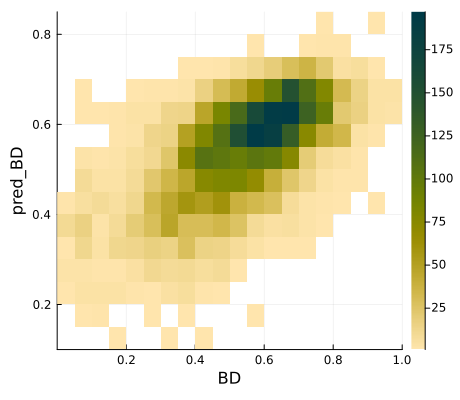

Plotting SOCconc: valid points = 56117


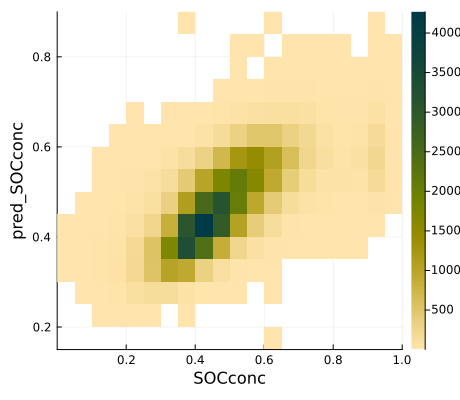

Plotting CF: valid points = 5194


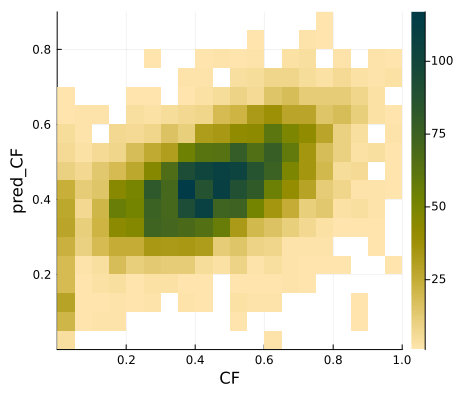

Plotting SOCdensity: valid points = 5194


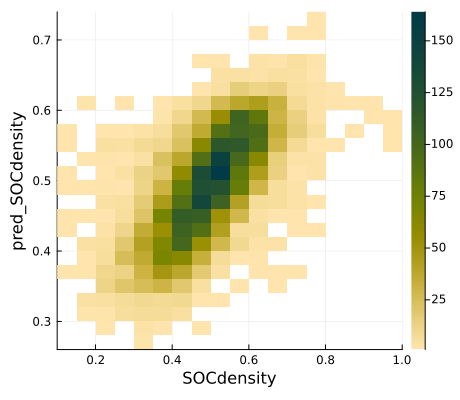

In [20]:
for tgt in ["BD", "SOCconc", "CF", "SOCdensity"]

    true_vals = rlt_pred[:, Symbol(tgt)]
    pred_vals = rlt_pred[:, Symbol("pred_", tgt)]

    # 过滤掉 invalid 值（避免 NaN 出图报错）
    mask = map(!isnan, true_vals) .& map(!isnan, pred_vals)
    x = true_vals[mask]
    y = pred_vals[mask]

    println("Plotting $tgt: valid points = ", length(x))

    plt = histogram2d(
        x, y;
        nbins = (30, 30),
        cbar = true,
        xlab = tgt,
        ylab = "pred_$tgt",
        color = cgrad(:bamako, rev=true),
        normalize = false,
        size = (460, 400),
    )

    display(plt)
end

Variable: pred_BD
  Valid count = 56117
  Min = 0.04835715876411407
  Max = 0.8312531435301485



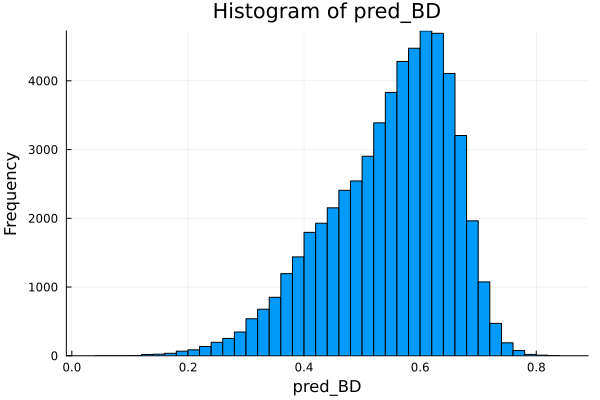

Variable: pred_SOCconc
  Valid count = 56117
  Min = 0.15762028
  Max = 0.88487977



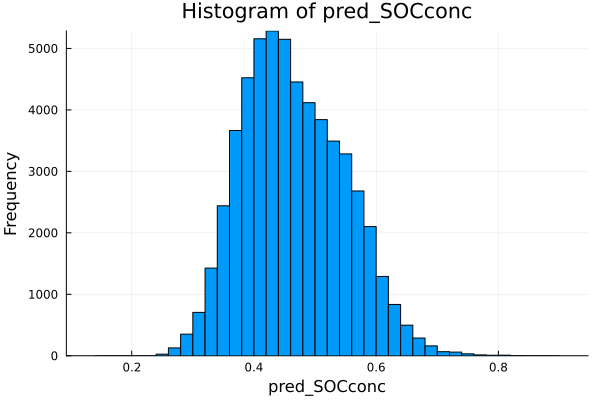

Variable: pred_CF
  Valid count = 56117
  Min = 0.0023913544
  Max = 0.883293



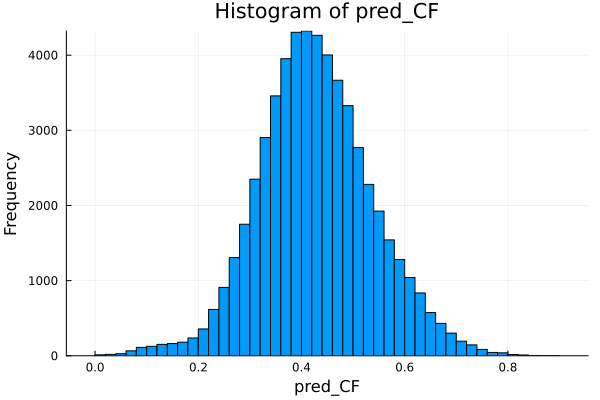

Variable: pred_SOCdensity
  Valid count = 56117
  Min = 0.15938038764298393
  Max = 0.8265542778985527



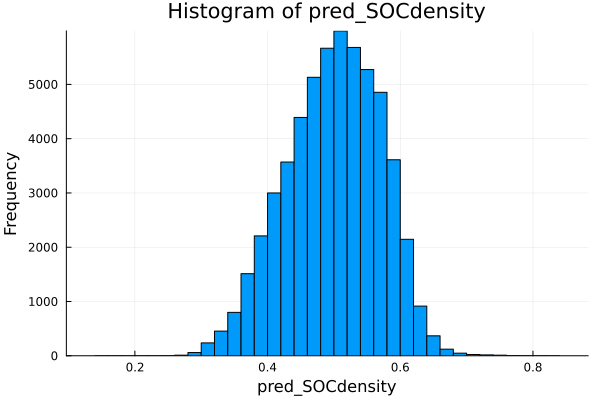

In [21]:
for col in ["pred_BD", "pred_SOCconc", "pred_CF", "pred_SOCdensity"]

    vals = rlt_pred[:, col]

    # 有效值（非 missing 且非 NaN）
    valid_vals = filter(x -> !ismissing(x) && !isnan(x), vals)

    n_valid = length(valid_vals)
    vmin = minimum(valid_vals)
    vmax = maximum(valid_vals)

    println("Variable: $col")
    println("  Valid count = $n_valid")
    println("  Min = $vmin")
    println("  Max = $vmax\n")

    histogram(
        vals;
        bins = 50,
        xlabel = col,
        ylabel = "Frequency",
        title = "Histogram of $col",
        lw = 1,
        legend = false
    )
    display(current())
end
